# Data Setup


## (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/"
if not os.path.exists(datadir):
  !ln -s "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/" $datadir # TODO: Fill your assignment3 path
os.chdir(datadir)
!pwd

/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project


## data download

In [ ]:

!unzip "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/train.zip" -d "/content/data2"


串流輸出內容已截斷至最後 5000 行。
  inflating: /content/data2/train/e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data2/__MACOSX/train/._e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data2/train/8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/__MACOSX/train/._f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/train/3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/__MACOSX/train/._3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/train/e2774572-bbbb-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content

## Dataloader

### dataloader

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import random
import numpy as np


In [ ]:
class CustomSingleLabelRotationDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, id_list=None):
        self.img_dir = img_dir
        self.transform = transform
        self.colors = ['red', 'green', 'blue', 'yellow']

        df = pd.read_csv(csv_path)
        id2labels = {row['Id']: list(map(int, row['Target'].split())) for _, row in df.iterrows()}

        all_ids_in_csv = set(id2labels.keys())
        all_files = os.listdir(img_dir)
        all_ids_on_disk = set(fname.split('_')[0] for fname in all_files if fname.endswith('_red.png'))
        valid_ids = sorted(all_ids_in_csv & all_ids_on_disk)
        available_ids = sorted(set(id_list) & set(valid_ids)) if id_list else valid_ids

        all_labels = set(label for labels in id2labels.values() for label in labels)
        self.label_map = {label: i for i, label in enumerate(sorted(all_labels))}
        self.num_classes = len(self.label_map)

        # Flatten samples to (image_id, label) pairs
        self.samples = []
        for img_id in available_ids:
            for label in id2labels[img_id]:
                self.samples.append((img_id, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_id, label = self.samples[idx]
        rotation_angle = random.choice([0, 90, 180, 270])

        channels = []
        for color in self.colors:
            path = os.path.join(self.img_dir, f"{img_id}_{color}.png")
            img = Image.open(path).convert('L')
            img = img.rotate(rotation_angle)
            channels.append(img)

        image = np.stack([np.array(ch) for ch in channels], axis=0)
        image = torch.from_numpy(image).float() / 255.0

        if self.transform:
            image = self.transform(image)

        label_index = self.label_map[label]
        return image, label_index


In [ ]:
image_size = (32, 32)
batch_size = 64

In [ ]:
from torchvision.transforms import Resize

transform_train = transforms.Compose([
    # transforms.RandomResizedCrop(512, scale=(0.8, 1.0), ratio=(0.9, 1.1))
    Resize(image_size),
])

transform_val = transforms.Compose([
    # transforms.CenterCrop(512)
    Resize(image_size),
])

In [ ]:
import os
import random
from sklearn.model_selection import train_test_split

# ID
img_dir = '/content/data2/train'
all_files = os.listdir(img_dir)
all_ids = sorted(set(
    fname.split('_')[0]
    for fname in all_files if fname.endswith('_red.png')
))


train_ids, val_ids = train_test_split(all_ids, test_size=0.1, random_state=42)

train_dataset = CustomSingleLabelRotationDataset(
    csv_path='data2/train.csv',
    img_dir=img_dir,
    transform=transform_train,
    id_list=train_ids
)

val_dataset = CustomSingleLabelRotationDataset(
    csv_path='data2/train.csv',
    img_dir=img_dir,
    transform=transform_val,
    id_list=val_ids
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # collate_fn=custom_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    # collate_fn=custom_collate_fn
)


Image shape: torch.Size([64, 4, 32, 32])
Label shape: torch.Size([64])


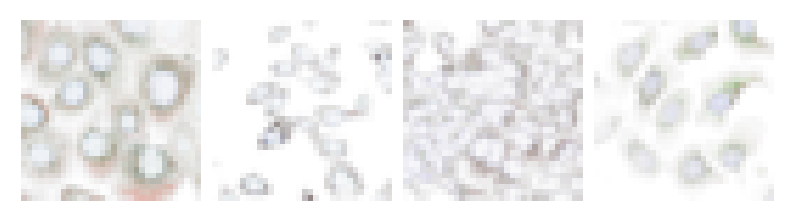

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# 拿到一個 batch（注意：custom_collate_fn 回傳的是 dict）
for images, labels in train_loader:

    # 只取前 4 張
    imgs = images[:4]
    grid = torchvision.utils.make_grid(imgs, nrow=4)

    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)

    # 把 tensor 轉為 numpy 並顯示圖像
    npimg = grid.numpy()
    plt.figure(figsize=(10, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # C, H, W → H, W, C
    plt.axis('off')
    plt.show()

    break


# model

## DDPM pretrained Definition

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# ----------- Class Conditional UNet (Minimal) -----------
class ClassConditionalUNet(nn.Module):
    def __init__(self, in_channels=4, num_classes=28, base_channels=64):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, base_channels)
        self.in_channels = in_channels
        self.base_channels = base_channels

        self.conv1 = nn.Conv2d(in_channels + base_channels, base_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(base_channels, base_channels, 3, padding=1)
        self.conv3 = nn.Conv2d(base_channels, in_channels, 3, padding=1)

    def forward(self, x, t, class_labels):
        B, C, H, W = x.shape
        c_emb = self.class_emb(class_labels).view(B, self.base_channels, 1, 1).expand(B, self.base_channels, H, W)
        x = torch.cat([x, c_emb], dim=1)  # shape: [B, C + base_channels, H, W]
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        out = self.conv3(h)
        return out


# ----------- Scheduler (DDPM) -----------
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

## train

In [ ]:
# ----------- Sampling Function -----------
@torch.no_grad()
def sample(model, noise_scheduler, class_label, num_steps=1000, image_size=32):
    model.eval()
    x = torch.randn(1, 4, image_size, image_size).to(device)
    label = torch.tensor([class_label], device=device)

    for t in reversed(range(num_steps)):
        t_tensor = torch.tensor([t], device=device)
        noise_pred = model(x, t_tensor, label)
        x = noise_scheduler.step(noise_pred, t_tensor, x).prev_sample
    return x.clamp(0, 1)

In [ ]:

import matplotlib.pyplot as plt
def show_sample(img_tensor):
    img_np = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    plt.imshow(img_np)
    plt.axis("off")
    plt.show()


Epoch 1/10: 100%|██████████| 716/716 [09:26<00:00,  1.26it/s, loss=0.132]


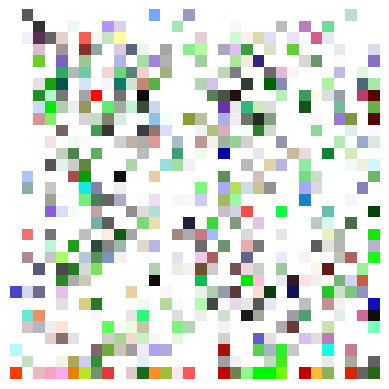

Epoch 1/10 Loss: 0.27639795777351495


Epoch 2/10: 100%|██████████| 716/716 [09:25<00:00,  1.27it/s, loss=0.161]


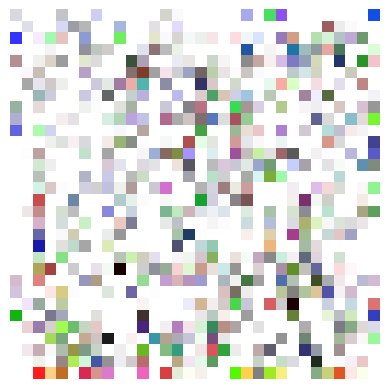

Epoch 2/10 Loss: 0.12154461764444352


Epoch 3/10: 100%|██████████| 716/716 [09:24<00:00,  1.27it/s, loss=0.137]


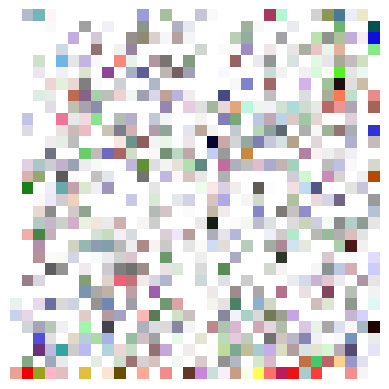

Epoch 3/10 Loss: 0.1043700125463848


Epoch 4/10: 100%|██████████| 716/716 [09:24<00:00,  1.27it/s, loss=0.085]


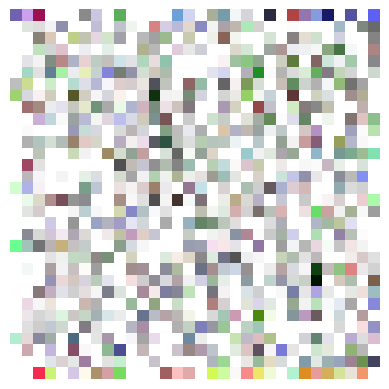

Epoch 4/10 Loss: 0.08908142824267043


Epoch 5/10: 100%|██████████| 716/716 [09:24<00:00,  1.27it/s, loss=0.0716]


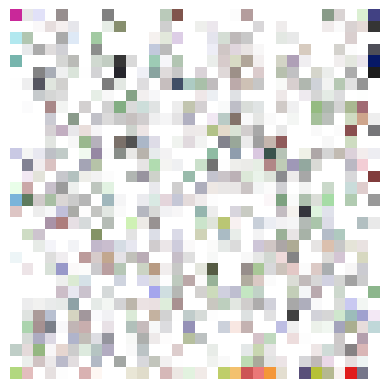

Epoch 5/10 Loss: 0.07174444535237284


Epoch 6/10: 100%|██████████| 716/716 [09:24<00:00,  1.27it/s, loss=0.0693]


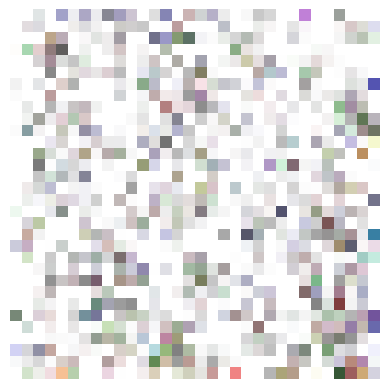

Epoch 6/10 Loss: 0.06125353780632329


Epoch 7/10: 100%|██████████| 716/716 [09:23<00:00,  1.27it/s, loss=0.0293]


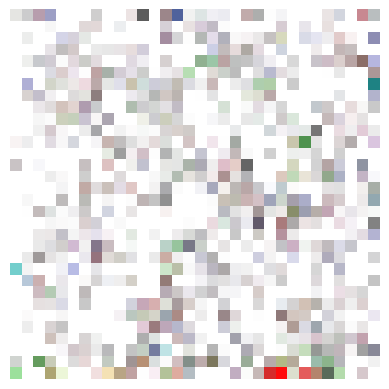

Epoch 7/10 Loss: 0.05376621612280025


Epoch 8/10: 100%|██████████| 716/716 [09:23<00:00,  1.27it/s, loss=0.0489]


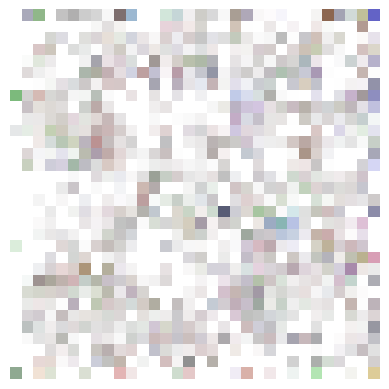

Epoch 8/10 Loss: 0.05050508460217265


Epoch 9/10: 100%|██████████| 716/716 [09:27<00:00,  1.26it/s, loss=0.0673]


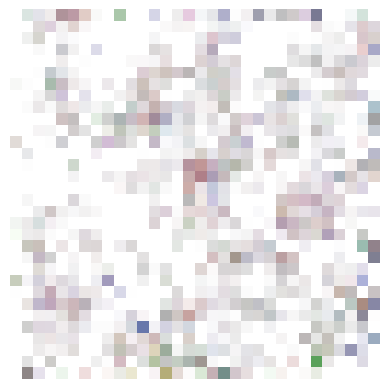

Epoch 9/10 Loss: 0.04572393409335497


Epoch 10/10: 100%|██████████| 716/716 [09:27<00:00,  1.26it/s, loss=0.039]


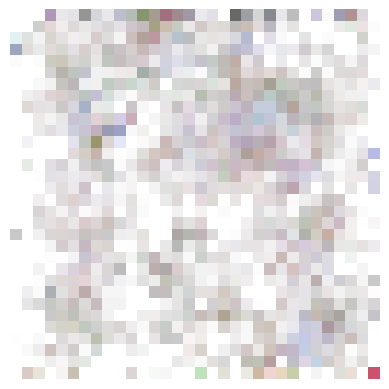

Epoch 10/10 Loss: 0.04322257105458798


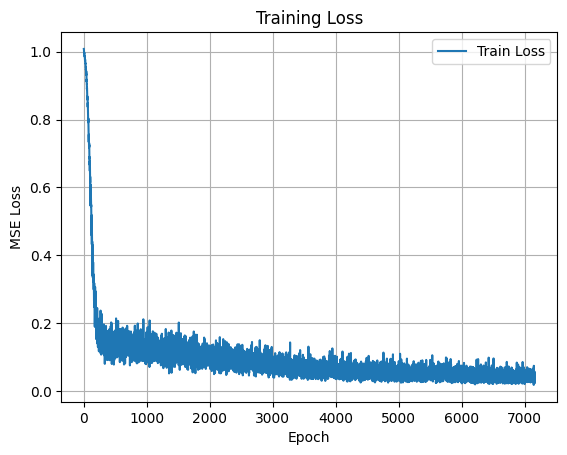

In [ ]:
# ----------- Training Config -----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassConditionalUNet(in_channels=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ----------- Training Loop -----------
num_epochs = 10
train_losses = []


for epoch in range(num_epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    epoch_loss = 0
    for x, labels in pbar:
        x = x.to(device)
        labels = labels.to(device)
        B = x.size(0)

        t = torch.randint(0, noise_scheduler.num_train_timesteps, (B,), device=device).long()
        noise = torch.randn_like(x)
        noisy_x = noise_scheduler.add_noise(x, noise, t)

        pred = model(noisy_x, t, labels)
        loss = F.mse_loss(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())
        train_losses.append(loss.item())
        epoch_loss += loss.item()

    img = sample(model, noise_scheduler, class_label=8)
    show_sample(img)
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss / len(train_loader)}")


plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()





Epoch 11/20:   0%|          | 0/716 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 11/20: 100%|██████████| 716/716 [09:29<00:00,  1.26it/s, loss=0.0549]


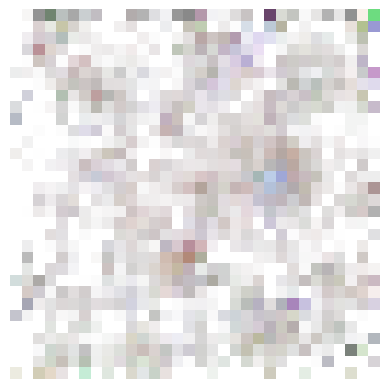

Epoch 11/10 Loss: 0.04060976380253387


Epoch 12/20: 100%|██████████| 716/716 [09:28<00:00,  1.26it/s, loss=0.0157]


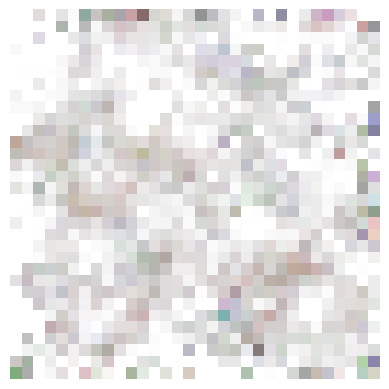

Epoch 12/10 Loss: 0.038113264788420836


Epoch 13/20: 100%|██████████| 716/716 [09:29<00:00,  1.26it/s, loss=0.0413]


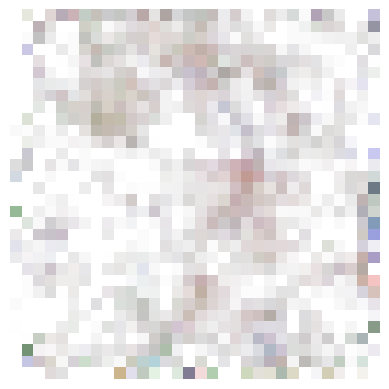

Epoch 13/10 Loss: 0.03499662015176061


Epoch 14/20: 100%|██████████| 716/716 [09:31<00:00,  1.25it/s, loss=0.0327]


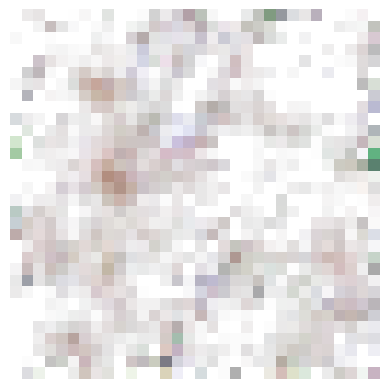

Epoch 14/10 Loss: 0.034998799522027536


Epoch 15/20: 100%|██████████| 716/716 [09:25<00:00,  1.27it/s, loss=0.0109]


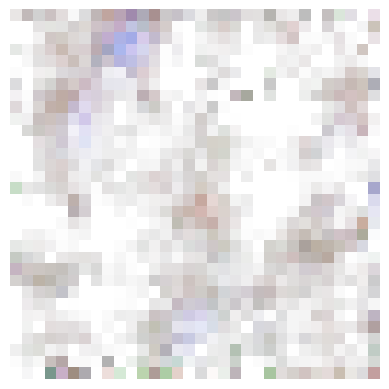

Epoch 15/10 Loss: 0.0329986349562464


Epoch 16/20: 100%|██████████| 716/716 [09:26<00:00,  1.26it/s, loss=0.0185]


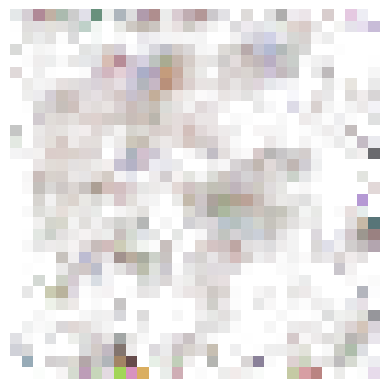

Epoch 16/10 Loss: 0.032984652324949064


Epoch 17/20: 100%|██████████| 716/716 [09:24<00:00,  1.27it/s, loss=0.0967]


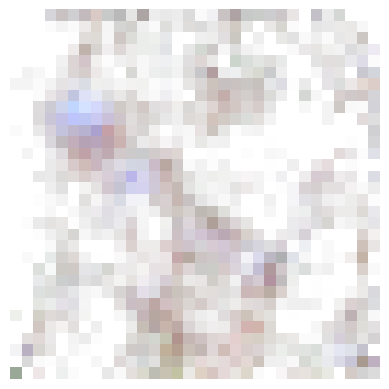

Epoch 17/10 Loss: 0.03120387436733607


Epoch 18/20: 100%|██████████| 716/716 [09:24<00:00,  1.27it/s, loss=0.0513]


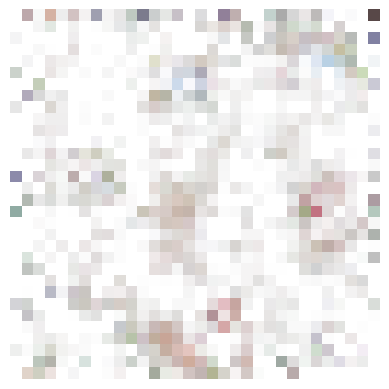

Epoch 18/10 Loss: 0.030623556243505476


Epoch 19/20: 100%|██████████| 716/716 [09:26<00:00,  1.26it/s, loss=0.105]


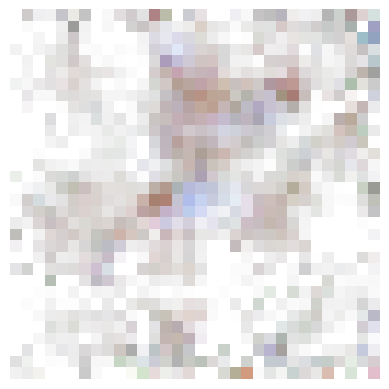

Epoch 19/10 Loss: 0.030295079570086723


Epoch 20/20: 100%|██████████| 716/716 [09:27<00:00,  1.26it/s, loss=0.0296]


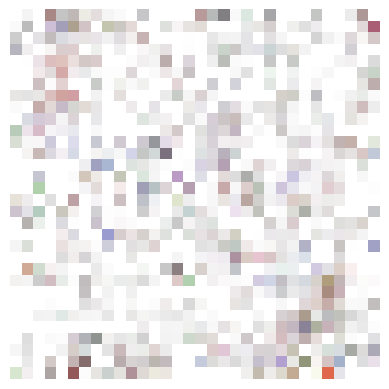

Epoch 20/10 Loss: 0.029399313761035824


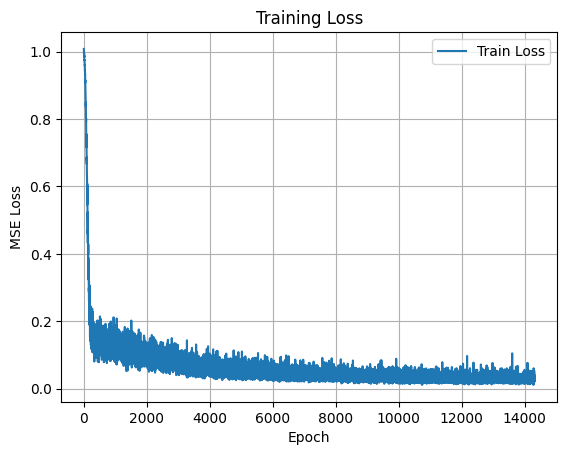

In [ ]:


for epoch in range(num_epochs, num_epochs + 10):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs + 10}")

    epoch_loss = 0
    for x, labels in pbar:
        x = x.to(device)
        labels = labels.to(device)
        B = x.size(0)

        t = torch.randint(0, noise_scheduler.num_train_timesteps, (B,), device=device).long()
        noise = torch.randn_like(x)
        noisy_x = noise_scheduler.add_noise(x, noise, t)

        pred = model(noisy_x, t, labels)
        loss = F.mse_loss(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())
        train_losses.append(loss.item())
        epoch_loss += loss.item()

    img = sample(model, noise_scheduler, class_label=8)
    show_sample(img)
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss / len(train_loader)}")


plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:

torch.save(model.state_dict(), "class_cond_unet.pth")


In [ ]:
@torch.no_grad()
def sample_per_class(model, noise_scheduler, class_labels, num_steps=1000, image_size=32):
    model.eval()
    imgs = []

    shared_noise = torch.randn(1, 4, image_size, image_size).to(device)

    for label in class_labels:
        x = shared_noise.clone()
        label_tensor = torch.tensor([label], device=device)

        for t in reversed(range(num_steps)):
            t_tensor = torch.tensor([t], device=device)
            noise_pred = model(x, t_tensor, label_tensor)
            x = noise_scheduler.step(noise_pred, t_tensor.item(), x).prev_sample  # 👈 .item()

        imgs.append(x)

    return torch.cat(imgs, dim=0)  # shape: [B, 4, H, W]


# ----------- Show Samples (Multi-class) -----------
def show_sample(img_tensor):
    img_tensor = img_tensor.cpu()
    B = img_tensor.size(0)
    fig, axes = plt.subplots(1, B, figsize=(B * 3, 3))
    if B == 1:
        axes = [axes]
    for i in range(B):
        img_np = img_tensor[i].squeeze().permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].axis("off")
    plt.show()

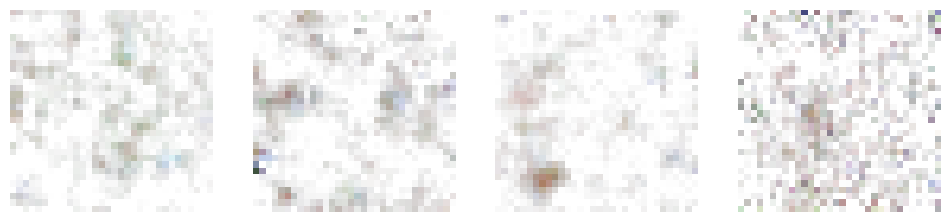

In [ ]:
imgs = sample_per_class(model, noise_scheduler, class_labels=[1, 3, 7, 8])
show_sample(imgs)


Epoch 21/20:   0%|          | 0/716 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 21/20: 100%|██████████| 716/716 [09:27<00:00,  1.26it/s, loss=0.00986]


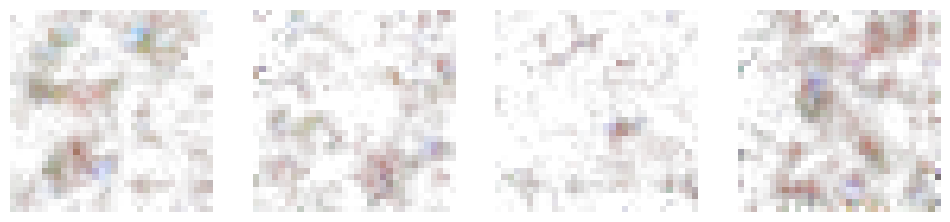

Epoch 21/10 Loss: 0.029602646372442306


Epoch 22/20: 100%|██████████| 716/716 [09:29<00:00,  1.26it/s, loss=0.0196]


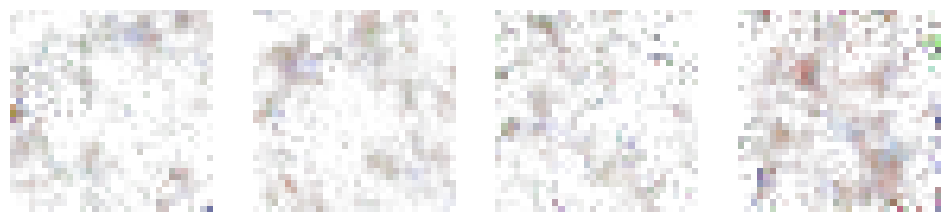

Epoch 22/10 Loss: 0.02925397875047596


Epoch 23/20: 100%|██████████| 716/716 [09:26<00:00,  1.26it/s, loss=0.0806]


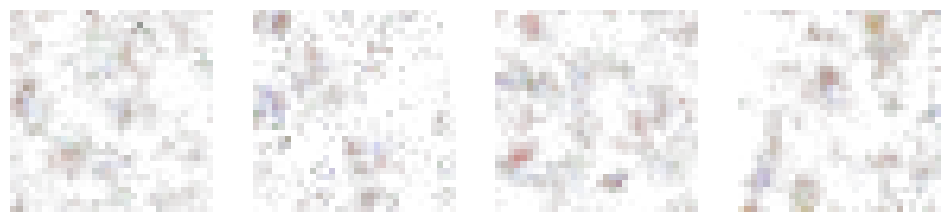

Epoch 23/10 Loss: 0.028656309552480306


Epoch 24/20: 100%|██████████| 716/716 [09:28<00:00,  1.26it/s, loss=0.0151]


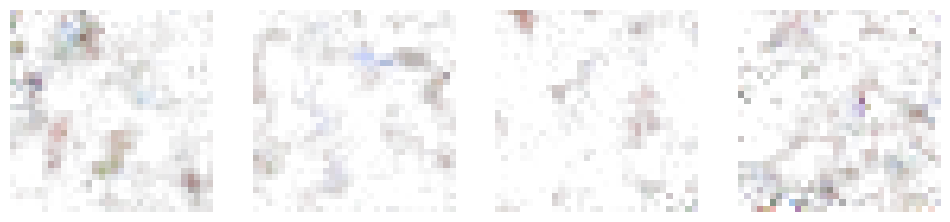

Epoch 24/10 Loss: 0.028245861629055364


Epoch 25/20: 100%|██████████| 716/716 [09:30<00:00,  1.26it/s, loss=0.0246]


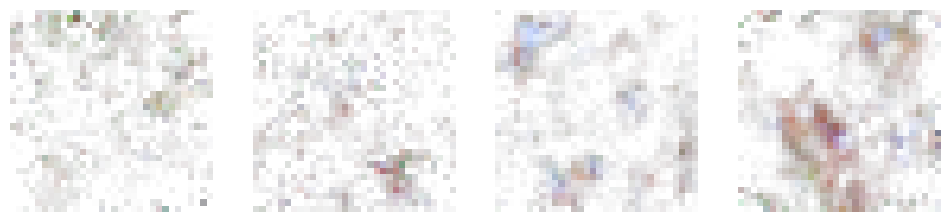

Epoch 25/10 Loss: 0.028764017195539685


Epoch 26/20: 100%|██████████| 716/716 [09:30<00:00,  1.26it/s, loss=0.0306]


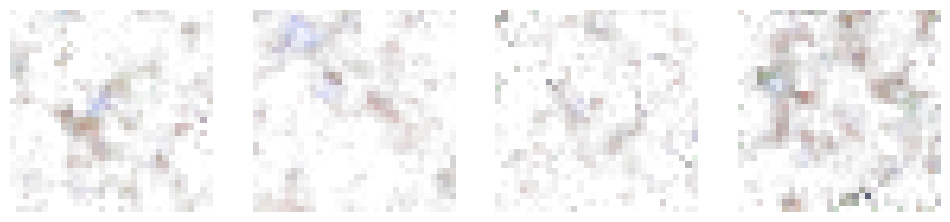

Epoch 26/10 Loss: 0.02812307606211879


Epoch 27/20: 100%|██████████| 716/716 [09:27<00:00,  1.26it/s, loss=0.0194]


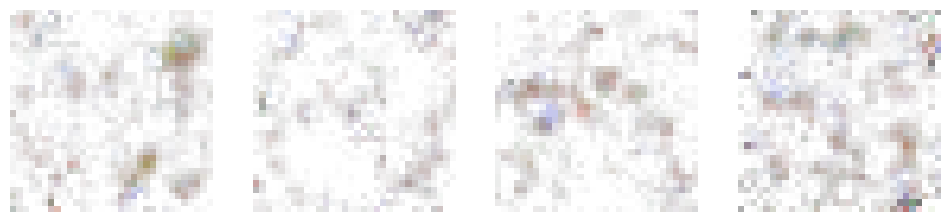

Epoch 27/10 Loss: 0.028058385946033472


Epoch 28/20: 100%|██████████| 716/716 [09:27<00:00,  1.26it/s, loss=0.0318]


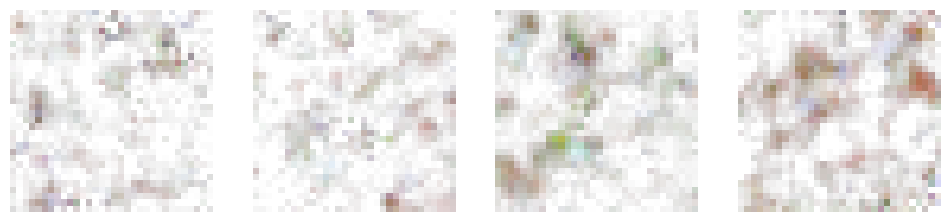

Epoch 28/10 Loss: 0.02777300747865863


Epoch 29/20: 100%|██████████| 716/716 [09:28<00:00,  1.26it/s, loss=0.0289]


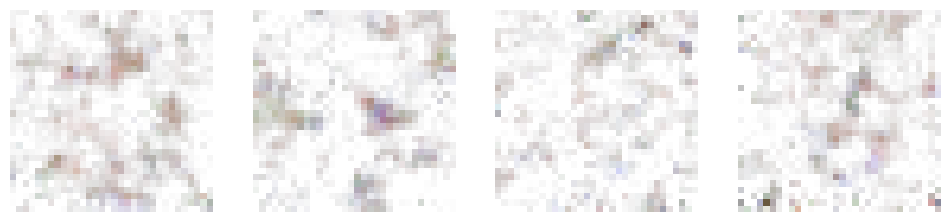

Epoch 29/10 Loss: 0.027192018918339268


Epoch 30/20: 100%|██████████| 716/716 [09:27<00:00,  1.26it/s, loss=0.0234]


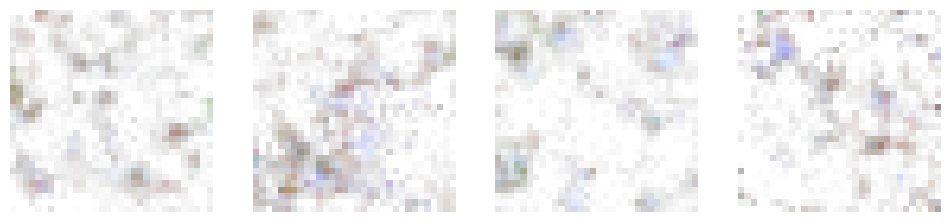

Epoch 30/10 Loss: 0.02717154861854483


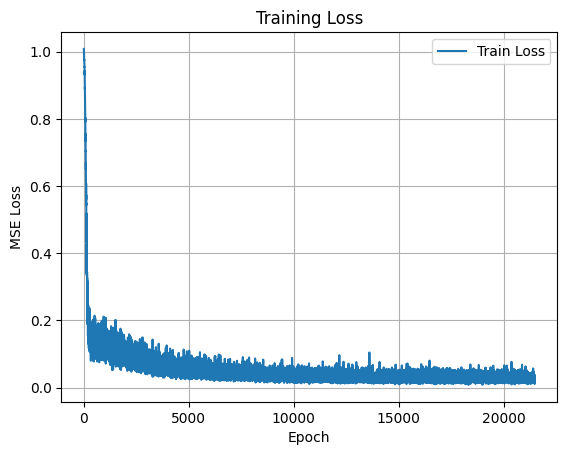

In [ ]:


for epoch in range(num_epochs+10, num_epochs + 20):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs + 10}")

    epoch_loss = 0
    for x, labels in pbar:
        x = x.to(device)
        labels = labels.to(device)
        B = x.size(0)

        t = torch.randint(0, noise_scheduler.num_train_timesteps, (B,), device=device).long()
        noise = torch.randn_like(x)
        noisy_x = noise_scheduler.add_noise(x, noise, t)

        pred = model(noisy_x, t, labels)
        loss = F.mse_loss(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())
        train_losses.append(loss.item())
        epoch_loss += loss.item()

    imgs = sample_per_class(model, noise_scheduler, class_labels=[1, 3, 7, 8])
    show_sample(imgs)
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss / len(train_loader)}")


plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs + 20
}, f"class_cond_unet_checkpoint{num_epochs + 20}.pth")
